# Lifetimes

We calculate the lifetime of Rydberg states and analyze which transitions contribute to it. The calculations can be performed with a few lines of code; most of the code within this notebook is only needed for plotting.

We import the libraries that we will use within the notebook and initialize PairInteraction's database.

In [ ]:
# %pip install -q pairinteraction # Uncomment for installation on Colab

from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction as pi
from scipy.optimize import curve_fit

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

As a quick example, we show how to calculate the lifetime of the Rubidium $|60S,m=1/2\rangle$ state via `ket.get_lifetime`. At zero temperature, the lifetime is determined by the spontaneous decay. If the temperature is non-zero, black body radiation can drive transitions to neighboring Rydberg states, reducing the lifetime.

In [3]:
ket = pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)

temperature = 300  # Kelvin
lifetime_0 = ket.get_lifetime()
lifetime = ket.get_lifetime(temperature, temperature_unit="K")

print(f"Lifetime at T=0: {lifetime_0.to('mus'):.2f}")
print(f"Lifetime at T={temperature}K: {lifetime.to('mus'):.2f}")

The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.
The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.
The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.


Lifetime at T=0: 239.07 microsecond
Lifetime at T=300K: 104.73 microsecond


## Transition rates contributing to the Rydberg lifetime

To analyze which transitions contribute to the lifetime, we can obtain the transition rates from spontaneous decay (`ket.get_spontaneous_transition_rates`) and black body radiation (`ket.get_black_body_transition_rates`).

The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.
The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.


Number of possible spontaneous decay transitions: 180
Number of considered BBR transitions: 235


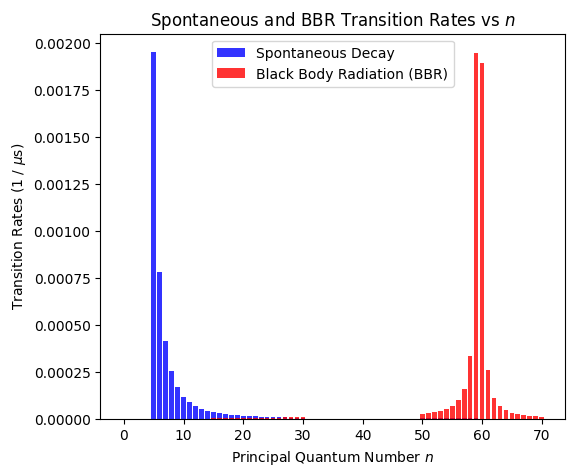

In [ ]:
# Calculate the transition rates
kets_sp, transition_rates_sp = ket.get_spontaneous_transition_rates(unit="1/mus")
print(f"Number of possible spontaneous decay transitions: {len(transition_rates_sp)}")

kets_bbr, transition_rates_bbr = ket.get_black_body_transition_rates(
    temperature, "kelvin", unit="1/mus"
)
print(f"Number of considered BBR transitions: {len(transition_rates_bbr)}")

# Plot the transition rates
fig, ax = plt.subplots(figsize=(6, 5))

n_list = np.arange(0, np.max([s.n for s in kets_bbr]) + 1)
rates_summed = {}
for key, kets, rates in [
    ("BBR", kets_bbr, transition_rates_bbr),
    ("SP", kets_sp, transition_rates_sp),
]:
    rates_summed[key] = np.zeros(len(n_list))
    for i, s in enumerate(kets):
        rates_summed[key][s.n] += rates[i]

ax.bar(n_list, rates_summed["SP"], label="Spontaneous Decay", color="blue", alpha=0.8)
ax.bar(n_list, rates_summed["BBR"], label="Black Body Radiation (BBR)", color="red", alpha=0.8)
ax.legend()

ax.set_xlabel("Principal Quantum Number $n$")
ax.set_ylabel(r"Transition Rates (1 / $\mu$s)")
ax.set_title("Spontaneous and BBR Transition Rates vs $n$")

plt.show()

## Lifetime scaling with the principal quantum number

As a more sophisticated example, we study how the lifetime scales with the effective principal quantum number $\nu$. Our numerics reproduce the $\nu^3$ scaling which one expects for states with a small angular quantum number $l$. For circular states, the lifetime scales as $\nu^5$.

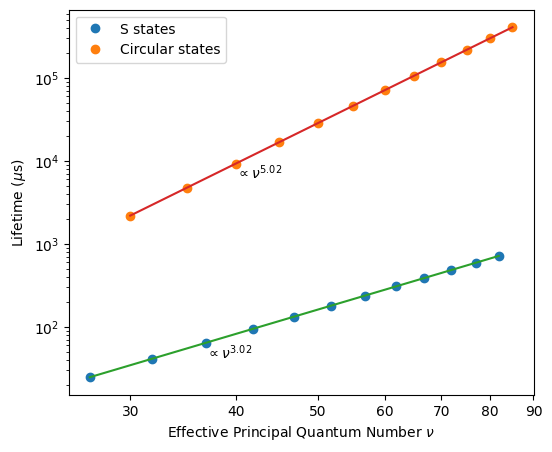

In [ ]:
n_list = list(range(30, 90, 5))


def fit_function(x: np.ndarray, a: float, b: float) -> np.typing.NDArray[Any]:
    return a * x + b


# Calculate lifetimes for S states
kets_s = [pi.KetAtom("Rb", n=n, l=0, j=0.5, m=0.5) for n in n_list]
nu_s = [ket.nu for ket in kets_s]
lifetimes_s = [ket.get_lifetime(unit="mus") for ket in kets_s]
popt_s, _ = curve_fit(fit_function, np.log(nu_s), np.log(lifetimes_s))

# Calculate lifetimes for circular states
kets_circular = [pi.KetAtom("Rb", n=n, l=n - 1, j=n - 0.5, m=n - 0.5) for n in n_list]
nu_circular = [ket.nu for ket in kets_circular]
lifetimes_circular = [ket.get_lifetime(unit="mus") for ket in kets_circular]
popt_circular, _ = curve_fit(fit_function, np.log(nu_circular), np.log(lifetimes_circular))

# Plot the scaling of the lifetimes
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(nu_s, lifetimes_s, "o", label="S states")
ax.plot(nu_circular, lifetimes_circular, "o", label="Circular states")

fit_s = np.exp(fit_function(np.log(nu_s), *popt_s))
fit_circular = np.exp(fit_function(np.log(nu_circular), *popt_circular))
ax.plot(nu_s, fit_s)
ax.plot(nu_circular, fit_circular)

ax.text(nu_s[2], fit_s[2], rf"$\propto \nu^{{{popt_s[0]:.2f}}}$", verticalalignment="top")
ax.text(
    nu_circular[2],
    fit_circular[2],
    rf"$\propto \nu^{{{popt_circular[0]:.2f}}}$",
    verticalalignment="top",
)

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"Effective Principal Quantum Number $\nu$")
ax.set_ylabel(r"Lifetime ($\mu$s)")

ax.set_xticks([30, 40, 50, 60, 70, 80, 90])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()